In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, mean_squared_error)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import (ElasticNetCV, LassoCV, RidgeCV)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import (RandomizedSearchCV, GridSearchCV)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)


In [2]:
# read in the dataset
df = pd.read_csv("data_for_modeling.csv")
df.head()

,role,seniority,avg_salary,state,company_rating,company_size,sector,company_age,city,region
0,data scientist,2,72.0,NM,3.8,2.0,Aerospace & Defense,47.0,other,West
1,data scientist,2,87.5,MD,3.4,3.0,Health Care,36.0,other,South
2,data scientist,2,85.0,FL,4.8,2.0,Business Services,10.0,other,South
3,data scientist,2,76.5,WA,3.8,3.0,"Oil, Gas, Energy & Utilities",55.0,Richland,West
4,data scientist,2,114.5,NY,2.9,1.0,Business Services,22.0,New York,Northeast


In [3]:
# drop city and state from the dataset as these will create a sparse matrix if used as dummy variables (too many dimensions)
df = df.drop(['city', 'state'], axis =1)

In [4]:
# get dummy variables for all of the categorical variables in the dataframe (role, sector, region)
df_modeling = pd.get_dummies(df)

In [5]:
# look at the details of the new data created
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   seniority                            742 non-null    int64  
 1   avg_salary                           742 non-null    float64
 2   company_rating                       742 non-null    float64
 3   company_size                         742 non-null    float64
 4   company_age                          742 non-null    float64
 5   role_data analyst                    742 non-null    uint8  
 6   role_data engineer                   742 non-null    uint8  
 7   role_data scientist                  742 non-null    uint8  
 8   role_director                        742 non-null    uint8  
 9   role_machine learning engineer       742 non-null    uint8  
 10  role_manager                         742 non-null    uint8  
 11  role_other                      

In [6]:
df['company_size'].value_counts()

3.0    366
2.0    251
1.0    125
Name: company_size, dtype: int64

In [7]:
# look at the range of values for each column to ensure there are no strange values
df_modeling.describe()

,seniority,avg_salary,company_rating,company_size,company_age,role_data analyst,role_data engineer,role_data scientist,role_director,role_machine learning engineer,...,sector_Information Technology,sector_Insurance,sector_Manufacturing,"sector_Oil, Gas, Energy & Utilities",sector_Retail,sector_other,region_Midwest,region_Northeast,region_South,region_West
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,...,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,2.051213,101.484501,3.688372,2.324798,50.030347,0.192722,0.160377,0.376011,0.017520,0.020216,...,0.242588,0.092992,0.045822,0.018868,0.020216,0.095687,0.138814,0.311321,0.264151,0.285714
std,0.340782,37.482449,0.566104,0.746312,52.233003,0.394703,0.367203,0.484710,0.131288,0.140832,...,0.428937,0.290617,0.209240,0.136150,0.140832,0.294360,0.345986,0.463346,0.441177,0.452059
min,1.000000,15.500000,1.900000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,73.500000,3.300000,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,97.500000,3.700000,2.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,122.500000,4.000000,3.000000,59.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,3.000000,254.000000,5.000000,3.000000,276.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Scaling Data and Splitting

In [8]:
# predictor vars
X = df_modeling.loc[:, df_modeling.columns != 'avg_salary']
# response variable
y = df_modeling['avg_salary']

# create the train test split with 80% of the data in the training set (dataset isn't very large)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# initialize the standard scaler object
# this standardizes the features to mean = 0, and standard deviation = 1
scaler = StandardScaler()
# created a scaled version of the X_train set by fitting and transforming the scaler to this dataset
X_train_scaled = scaler.fit_transform(X_train)
# use the standard scaler fit on the training data to scale the test set so there is no data leakage
X_test_scaled = scaler.transform(X_test)

## Linear Regression

Lets start the modeling with a very simple linear regression model to predict average salary. We will then work up to regularized regression using Lasso and Ridge Regression.

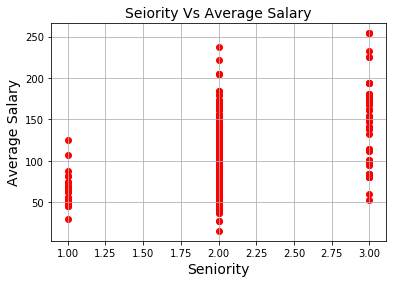

In [9]:
plt.scatter(df['seniority'], df['avg_salary'], color='red')
plt.title('Seiority Vs Average Salary', fontsize=14)
plt.xlabel('Seniority', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.grid(True)
plt.show()

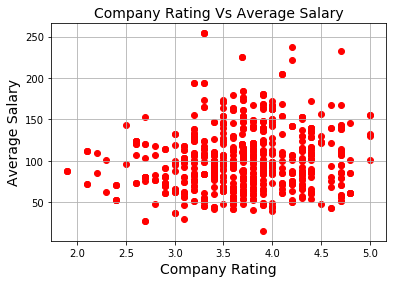

In [10]:
# the log transform of company_rating and avg_salary gives the most linear and tight fit
plt.scatter(df['company_rating'], df['avg_salary'], color='red')
plt.title('Company Rating Vs Average Salary', fontsize=14)
plt.xlabel('Company Rating', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.grid(True)
plt.show()

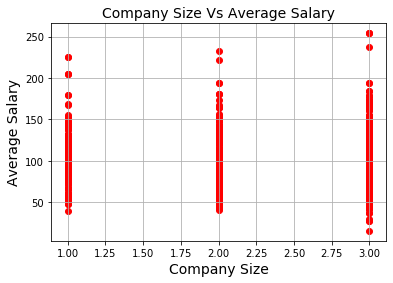

In [11]:
plt.scatter(df['company_size'], df['avg_salary'], color='red')
plt.title('Company Size Vs Average Salary', fontsize=14)
plt.xlabel('Company Size', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.grid(True)
plt.show()

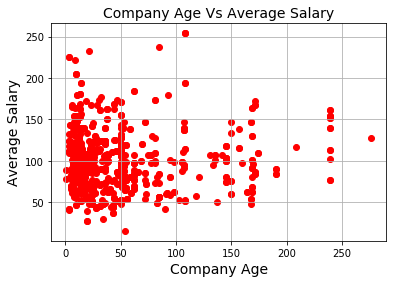

In [12]:
# the log transform of company_rating and avg_salary gives the most linear and tight fit
plt.scatter(df['company_age'], df['avg_salary'], color='red')
plt.title('Company Age Vs Average Salary', fontsize=14)
plt.xlabel('Company Age', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.grid(True)
plt.show()

In [13]:
X_reg = sm.add_constant(X_train)
#X_reg[['company_rating','company_age']] = X_reg[['company_rating','company_age']].apply(np.log)
lin_reg = sm.OLS(y_train, X_reg).fit()
lin_reg.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     14.89
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           4.19e-51
Time:                        13:15:28   Log-Likelihood:                -2816.6
No. Observations:                 593   AIC:                             5691.
Df Residuals:                     564   BIC:                             5818.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  15.2070      9.676      1.572      0.117      -3.798      34.212
seniority                              26.3361      4.035      6.526      0.000      18.410      34.262
company_rating                          2.7571      2.458      1.122      0.262      -2.071       7.585
company_size                            1.6602      1.930      0.860      0.390      -2.131       5.451
company_age                             0.0496      0.028      1.753      0.080      -0.006       0.105
role_data analyst                     -19.4485      3.865     -5.032      0.000     -27.040     -11.857
role_data engineer                      7.5525      4.066      1.857      0.064      -0.434      15.539
role_data scientist                    21.2992      3.554      5.993      0.000      14.318      28.280
role_director                          38.7428     10.486      3.695      0.000      18.147      59.339
role_machine learning engineer         15.1813      8.939      1.698      0.090      -2.377      32.740
role_manager                          -13.8001      7.002     -1.971      0.049     -27.553      -0.048
role_other                             -6.8670      4.222     -1.626      0.104     -15.160       1.426
role_product analyst                  -32.4861     18.793     -1.729      0.084     -69.399       4.426
role_research scientist                 5.9722      7.701      0.776      0.438      -9.154      21.098
role_software engineer                 -0.9392     13.591     -0.069      0.945     -27.634      25.755
sector_Aerospace & Defense              1.7459      6.625      0.264      0.792     -11.267      14.759
sector_Biotech & Pharmaceuticals       14.9399      3.705      4.032      0.000       7.663      22.217
sector_Business Services                2.7333      3.791      0.721      0.471      -4.712      10.179
sector_Education                        9.8451      6.988      1.409      0.159      -3.881      23.572
sector_Finance                          3.6975      4.753      0.778      0.437      -5.638      13.033
sector_Government                      -1.7909      9.760     -0.183      0.854     -20.962      17.380
sector_Health Care                    -11.5266      4.822     -2.390      0.017     -20.998      -2.056
sector_Information Technology          14.9942      3.374      4.444      0.000       8.368      21.621
sector_Insurance                        3.1774      4.340      0.732      0.464      -5.348      11.703
sector_Manufacturing                    8.7672      5.674      1.545      0.123      -2.377      19.911
sector_Oil, Gas, Energy & Utilities   -33.9530      8.644     -3.928      0.000     -50.930     -16.976
sector_Retail                           3.6065      8.022      0.45

In [14]:
X_reg = sm.add_constant(X_train[['seniority', 'role_data analyst',
              'role_data scientist', 'role_director', 'role_manager',
               'sector_Biotech & Pharmaceuticals',
              'sector_Health Care', 'sector_Information Technology',
              'sector_Oil, Gas, Energy & Utilities', 'region_West']])
# regressing the log of average salary on the subset of the predictors from the full model that are significant at 95% significance level
lin_reg2 = sm.OLS(y_train, X_reg).fit()
lin_reg2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_salary   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     37.12
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           3.28e-56
Time:                        13:15:28   Log-Likelihood:                -2834.4
No. Observations:                 593   AIC:                             5691.
Df Residuals:                     582   BIC:                             5739.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  37.4107      8.373      4.468      0.000      20.966      53.855
seniority                              25.9683      4.015      6.468      0.000      18.083      33.853
role_data analyst                     -20.3349      3.371     -6.033      0.000     -26.955     -13.715
role_data scientist                    20.1705      2.859      7.055      0.000      14.555      25.786
role_director                          43.1792     10.710      4.032      0.000      22.145      64.213
role_manager                          -11.7446      7.177     -1.636      0.102     -25.841       2.351
sector_Biotech & Pharmaceuticals       12.0456      3.654      3.296      0.001       4.868      19.223
sector_Health Care                    -19.6732      5.010     -3.927      0.000     -29.513      -9.833
sector_Information Technology          10.5488      3.030      3.481      0.001       4.598      16.500
sector_Oil, Gas, Energy & Utilities   -35.5516      9.204     -3.863      0.000     -53.629     -17.474
region_West                            14.8877      2.790      5.336      0.000       9.408      20.367
==============================================================================
Omnibus:                       73.739   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.834
Skew:                           0.695   Prob(JB):                     1.19e-35
Kurtosis:                       5.140   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# check the variance inflation factors (VIF) to make sure there is no multicollinearity
pd.Series([variance_inflation_factor(X_reg.values, i) 
               for i in range(X_reg.shape[1])], 
              index=X_reg.columns)

# no problems with multicollinearity (no VIF > 5)

const                                  49.148050
seniority                               1.232459
role_data analyst                       1.269592
role_data scientist                     1.337455
role_director                           1.201888
role_manager                            1.062889
sector_Biotech & Pharmaceuticals        1.149722
sector_Health Care                      1.132534
sector_Information Technology           1.189072
sector_Oil, Gas, Energy & Utilities     1.081331
region_West                             1.116048
dtype: float64

In [16]:
train_pred = lin_reg2.predict(X_reg)

In [17]:
RMSE_lin_reg = mean_squared_error(y_train, train_pred, squared = False)
print(RMSE_lin_reg)

28.812141683438544


In [18]:
MAE_lin_reg = mean_absolute_error(y_train, train_pred)
print(MAE_lin_reg)

22.202596845096174


In [19]:
pred = lin_reg2.predict(sm.add_constant(X_test[['seniority', 'role_data analyst',
              'role_data scientist', 'role_director', 'role_manager',
               'sector_Biotech & Pharmaceuticals',
              'sector_Health Care', 'sector_Information Technology',
              'sector_Oil, Gas, Energy & Utilities', 'region_West']]))

RMSE_lin_reg = mean_squared_error(y_test, pred, squared = False)
print(RMSE_lin_reg)

MAE_lin_reg = mean_absolute_error(y_test, pred)
print(MAE_lin_reg)

# these estimates are around $23,000 off on average

28.361232818268416
22.970572239364788


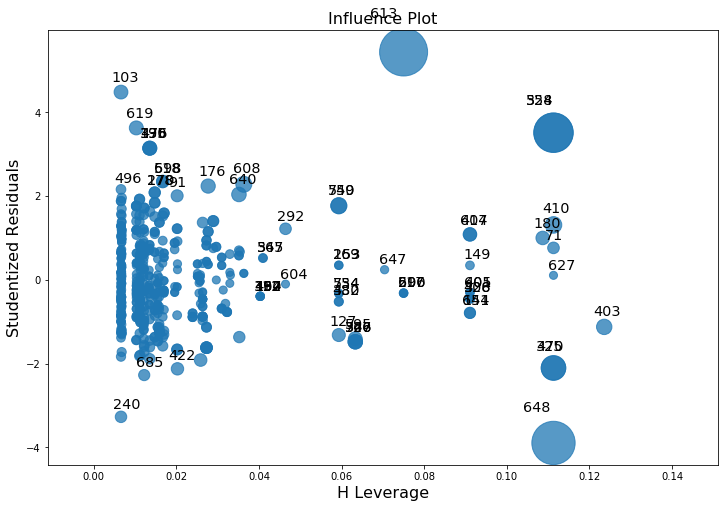

In [20]:
# look at the leverage vs residuals plot to see if there are any influential leverage points that could be removed 
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lin_reg2, ax=ax, criterion="cooks")

In [21]:
# check for cooks distance > 1 for influential leverage points to remove
sum(lin_reg2.get_influence().summary_frame()['cooks_d']>=1)

0

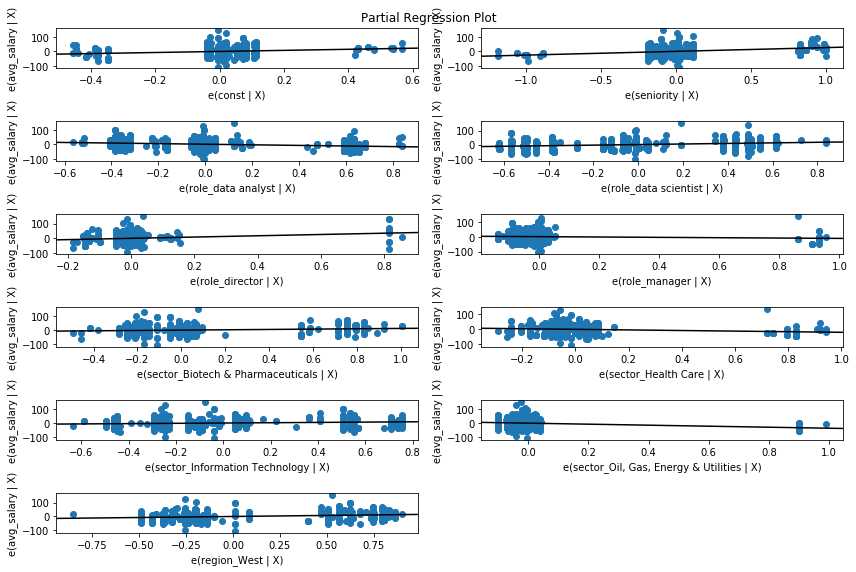

In [22]:
# plot regression plots to show the linear relationship between each independent variable and expected salary
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(lin_reg2, fig=fig)

## Lasso, Ridge, and Elastic Net Regression

In [23]:
# ratio close to 1 means lasso where l1 ratio close to 0 would mean ridge regression
# lasso sets many of the coefs to 0 and is useful for variable selection
# must use scaled data for all of these regularized regression methods because the weight of each variable coefficient 
# needs to be standardized for the penalty term
EN_reg = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 1], random_state = 42)
EN_reg.fit(X_train_scaled, y_train)
print("Training R Squared: {}".format(EN_reg.score(X_train_scaled, y_train)))
print("l1_ratio: {}".format(EN_reg.l1_ratio_))
alpha_optimal = EN_reg.alpha_
# index in the alphas array of the optimal alpha
opt_alpha_idx = np.where(EN_reg.alphas_==alpha_optimal)
print("Training RMSE: {}".format(np.sqrt(np.mean(EN_reg.mse_path_[opt_alpha_idx]))))
coefs = pd.Series(EN_reg.coef_, 
              index=X_train.columns)
print('***************Regression Coefficients**************')
print(coefs)


Training R Squared: 0.4196621855350472
l1_ratio: 0.6
Training RMSE: 29.27825016225859
***************Regression Coefficients**************
seniority                              7.951993
company_rating                         1.241141
company_size                           0.515423
company_age                            2.234198
role_data analyst                     -8.325490
role_data engineer                     1.090169
role_data scientist                    7.751832
role_director                          3.906885
role_machine learning engineer         1.186349
role_manager                          -2.558933
role_other                            -3.265007
role_product analyst                  -1.580940
role_research scientist                0.090289
role_software engineer                -0.263247
sector_Aerospace & Defense            -0.243038
sector_Biotech & Pharmaceuticals       3.309539
sector_Business Services              -0.415217
sector_Education                       0.6768

In [24]:
EN_pred = EN_reg.predict(X_test_scaled)

RMSE_EN_reg = mean_squared_error(y_test, EN_pred, squared = False)
print(RMSE_EN_reg)

MAE_EN_reg = mean_absolute_error(y_test, EN_pred)
print(MAE_EN_reg)

27.108330021416954
21.577254530367124


l1 ratio: 0.1, RMSE: 29.284952587155413, Number of Variables: 31
l1 ratio: 0.2, RMSE: 29.283368450933867, Number of Variables: 31
l1 ratio: 0.3, RMSE: 29.281561839583038, Number of Variables: 31
l1 ratio: 0.4, RMSE: 29.2796588737528, Number of Variables: 31
l1 ratio: 0.5, RMSE: 29.27837892560113, Number of Variables: 30
l1 ratio: 0.6, RMSE: 29.27825016225859, Number of Variables: 29
l1 ratio: 0.7, RMSE: 29.279447311467706, Number of Variables: 28
l1 ratio: 0.8, RMSE: 29.28330995295561, Number of Variables: 26
l1 ratio: 0.9, RMSE: 29.29579189560102, Number of Variables: 25
l1 ratio: 0.95, RMSE: 29.307617743681522, Number of Variables: 25
l1 ratio: 0.975, RMSE: 29.316838201288807, Number of Variables: 24
l1 ratio: 0.99, RMSE: 29.322234329740983, Number of Variables: 24
l1 ratio: 1, RMSE: 29.32610963401265, Number of Variables: 23
Best l1_ratio and alpha: 0.600000, 0.293808


Text(0.5, 1.0, 'L1 Ratio vs Elastic Net RMSE')

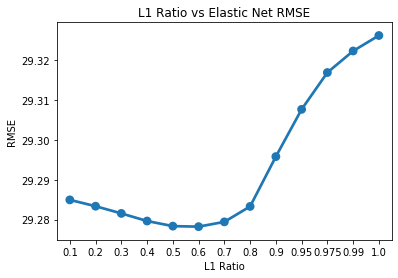

In [25]:
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
rmse_arr = []    
min_rmse = 1000
for r in l1_ratios:
    reg_en = ElasticNetCV(l1_ratio=r, cv=5)
    reg_en.fit(X_train_scaled, y_train)
    n_nonzeros = (reg_en.coef_ != 0).sum()
    _rmse = np.sqrt(np.mean(reg_en.mse_path_, axis=1)[
        np.where(reg_en.alphas_ == reg_en.alpha_)[0][0]])
    rmse_arr.append(_rmse)
    print("l1 ratio: {}, RMSE: {}, Number of Variables: {}".format(r, _rmse, n_nonzeros))
    if _rmse < min_rmse:
        min_rmse = _rmse
        best_l1_ratio = r
        best_alpha = reg_en.alpha_
   
print("Best l1_ratio and alpha: %f, %f" % (best_l1_ratio, best_alpha))

#plt.plot(l1_ratios, rmse_arr)
sns.pointplot(l1_ratios, rmse_arr)
plt.xlabel('L1 Ratio')
plt.ylabel('RMSE')
plt.title('L1 Ratio vs Elastic Net RMSE')

In [26]:
# Lasso
L_reg = LassoCV(random_state = 42)
L_reg.fit(X_train_scaled, y_train)
print("Training R Squared: {}".format(L_reg.score(X_train_scaled, y_train)))
alpha_optimal = L_reg.alpha_
# index in the alphas array of the optimal alpha
opt_alpha_idx = np.where(L_reg.alphas_==alpha_optimal)
print("Training RMSE: {}".format(np.sqrt(np.mean(L_reg.mse_path_[opt_alpha_idx]))))
coefs = pd.Series(L_reg.coef_, 
              index=X_train.columns)
print('***************Regression Coefficients**************')
print(coefs)



Training R Squared: 0.42077786440795445
Training RMSE: 29.32610963401265
***************Regression Coefficients**************
seniority                              8.531734
company_rating                         0.688396
company_size                           0.313468
company_age                            2.446289
role_data analyst                     -9.821669
role_data engineer                     0.000000
role_data scientist                    6.994988
role_director                          3.570452
role_machine learning engineer         0.665445
role_manager                          -2.985310
role_other                            -4.211921
role_product analyst                  -1.612000
role_research scientist               -0.000000
role_software engineer                -0.247632
sector_Aerospace & Defense            -0.000000
sector_Biotech & Pharmaceuticals       3.547836
sector_Business Services              -0.000000
sector_Education                       0.389963
sector_Fin

In [27]:
L_pred = L_reg.predict(X_test_scaled)

RMSE_L_reg = mean_squared_error(y_test, L_pred, squared = False)
print(RMSE_L_reg)

MAE_L_reg = mean_absolute_error(y_test, L_pred)
print(MAE_L_reg)

27.020036032335383
21.518098193442075


In [28]:
# Ridge regression
# must use LOOCV because the functionality is not up to date with LASSO and EN methods
R_reg = RidgeCV(store_cv_values = True)
R_reg.fit(X_train_scaled, y_train)
print("Training R Squared: {}".format(R_reg.score(X_train_scaled, y_train)))
coefs = pd.Series(R_reg.coef_, index=X_train.columns)
# chosen alpha is 10, which is at index 2 of the cv_values array
print("Training CV RMSE Score: {}".format(np.sqrt(np.mean(R_reg.cv_values_, axis = 0)[2])))
print('***************Regression Coefficients**************')
print(coefs)


Training R Squared: 0.4249173775564258
Training CV RMSE Score: 29.423292300032628
***************Regression Coefficients**************
seniority                              8.591304
company_rating                         1.538304
company_size                           1.168213
company_age                            2.573849
role_data analyst                     -8.927868
role_data engineer                     1.587346
role_data scientist                    8.637525
role_director                          4.309643
role_machine learning engineer         1.523874
role_manager                          -2.874572
role_other                            -3.661426
role_product analyst                  -2.020023
role_research scientist                0.428464
role_software engineer                -0.342979
sector_Aerospace & Defense            -0.656343
sector_Biotech & Pharmaceuticals       3.291201
sector_Business Services              -0.893999
sector_Education                       0.740050
s

In [29]:
R_pred = R_reg.predict(X_test_scaled)

RMSE_R_reg = mean_squared_error(y_test, R_pred, squared = False)
print(RMSE_L_reg)

MAE_R_reg = mean_absolute_error(y_test, R_pred)
print(MAE_R_reg)

27.020036032335383
21.147481775858996


## Support Vector Regression

In [30]:
sv_reg = SVR()
param_grid = {'kernel':['rbf', 'linear', 'poly'], 'C':[0.1, 1, 10, 100], 'gamma':[1,0.1, 0.01, 0.001]}
clf = GridSearchCV(sv_reg, param_grid, scoring = 'neg_root_mean_squared_error')
opt_svm = clf.fit(X_train_scaled, y_train)

In [31]:
print(opt_svm.best_params_)
print(opt_svm.best_score_)
print(opt_svm.scorer_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
-26.013709439265085
make_scorer(mean_squared_error, greater_is_better=False, squared=False)


In [32]:
svm_pred = opt_svm.predict(X_test_scaled)

RMSE_svm_reg = mean_squared_error(y_test, svm_pred, squared = False)
print(RMSE_svm_reg)

MAE_svm_reg = mean_absolute_error(y_test, svm_pred)
print(MAE_svm_reg)

21.79789351952316
11.39227082746488


## Random Forest Regression (Bagging)

In [33]:
rf_reg = RandomForestRegressor()
param_grid = {'n_estimators':[25, 50, 75, 100, 150], 'max_features':['auto', 'sqrt', 'log2'], 'min_samples_split':[2,3,4]}
clf = GridSearchCV(rf_reg, param_grid, scoring = 'neg_root_mean_squared_error')
opt_rf = clf.fit(X_train, y_train)

In [34]:
print(opt_rf.best_params_)
print(opt_rf.best_score_)
print(opt_rf.scorer_)

{'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 50}
-22.87303999919684
make_scorer(mean_squared_error, greater_is_better=False, squared=False)


In [35]:
rf_feature_importances = pd.Series(opt_rf.best_estimator_.feature_importances_, index = X_train.columns)
print(rf_feature_importances)

seniority                              0.076659
company_rating                         0.148231
company_size                           0.047231
company_age                            0.181562
role_data analyst                      0.069452
role_data engineer                     0.020612
role_data scientist                    0.091010
role_director                          0.035100
role_machine learning engineer         0.005566
role_manager                           0.015312
role_other                             0.023334
role_product analyst                   0.000613
role_research scientist                0.005330
role_software engineer                 0.000650
sector_Aerospace & Defense             0.003722
sector_Biotech & Pharmaceuticals       0.022864
sector_Business Services               0.016795
sector_Education                       0.004739
sector_Finance                         0.014739
sector_Government                      0.001994
sector_Health Care                     0

Text(0, 0.5, 'Feature')

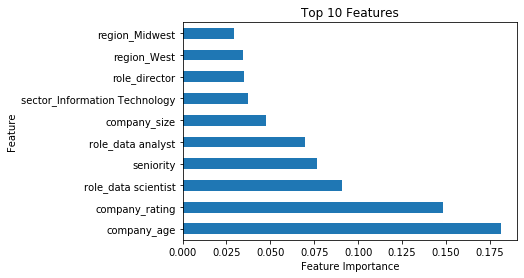

In [36]:
rf_feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

In [37]:
rf_pred = opt_rf.predict(X_test)

RMSE_rf_reg = mean_squared_error(y_test, rf_pred, squared = False)
print(RMSE_rf_reg)

MAE_rf_reg = mean_absolute_error(y_test, rf_pred)
print(MAE_rf_reg)

17.81652969571078
12.495133139297865


## Gradient Boosting Regression (Boosting)

In [38]:
# fixed learning rate of 0.1 (default) and find the optimal number of trees for this rate
gb_reg = GradientBoostingRegressor(random_state = 42)
param_grid = {'n_estimators':[25, 40, 50, 60, 75, 100, 150, 200]}
clf = GridSearchCV(gb_reg, param_grid, scoring = 'neg_root_mean_squared_error')
opt_gb = clf.fit(X_train, y_train)
print(opt_gb.best_params_)
print(opt_gb.best_score_)
print(opt_gb.scorer_)

{'n_estimators': 150}
-25.806873585667187
make_scorer(mean_squared_error, greater_is_better=False, squared=False)


In [39]:
# update regressor to optimal number of trees and tune the tree-based parameters
gb_reg2 = GradientBoostingRegressor(n_estimators = 150, random_state = 42)
param_grid = {'max_features':['auto', 'sqrt', 'log2'], 'min_samples_split':[2,3,4,5],
             'max_depth':[2,3]}
clf2 = GridSearchCV(gb_reg2, param_grid, scoring = 'neg_root_mean_squared_error')
opt_gb2 = clf2.fit(X_train, y_train)
print(opt_gb2.best_params_)
print(opt_gb2.best_score_)
print(opt_gb2.scorer_)


{'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 3}
-25.67121944721037
make_scorer(mean_squared_error, greater_is_better=False, squared=False)


In [40]:
gb_feature_importances = pd.Series(opt_gb2.best_estimator_.feature_importances_, index = X_train.columns)
print(gb_feature_importances)

seniority                              0.139215
company_rating                         0.101760
company_size                           0.017846
company_age                            0.157411
role_data analyst                      0.077383
role_data engineer                     0.011496
role_data scientist                    0.144499
role_director                          0.008509
role_machine learning engineer         0.001193
role_manager                           0.015706
role_other                             0.041977
role_product analyst                   0.002032
role_research scientist                0.012898
role_software engineer                 0.000000
sector_Aerospace & Defense             0.000506
sector_Biotech & Pharmaceuticals       0.020172
sector_Business Services               0.016726
sector_Education                       0.000983
sector_Finance                         0.010347
sector_Government                      0.001130
sector_Health Care                     0

Text(0, 0.5, 'Feature')

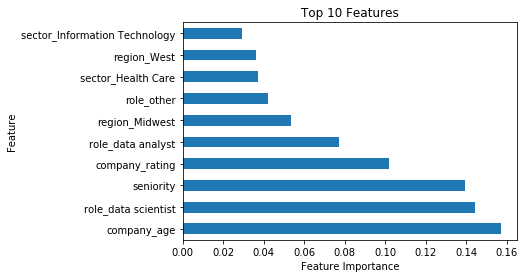

In [41]:
gb_feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

In [42]:
# TODO: interpret size of coefficients of the LASSO model to see which features are best for predicting salary